Defining map area ...

extract segments north of 60 S from Basemap
Importing Antarctic Digital Database shapefile.. 



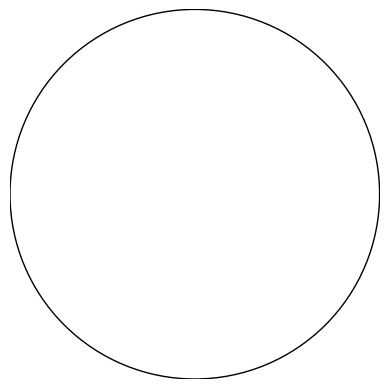

In [3]:
#! /usr/bin/env python3
"""
Plot coastline from the Antarctic Digital Database
> data from Clement Vic/Paul Holland

Last modified: 16 Mar 2021
"""

## Import modules
import numpy as np
from numpy import ma


import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as polyg

from mpl_toolkits.basemap import Basemap

import sys

# Define directories
#------------------------------------------------------------------
workdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
directorycoast = workdir + 'land_masks/holland_vic/'

# COASTLINES
#------------------------------------------------------------------
#------------------------------------------------------------------
print("Defining map area ...\n")
# coastline resolution can vary from coarse to fine: c, l, i, h, f
m = Basemap(projection='spstere',
            boundinglat=-49.5,
            lon_0=-180,
            resolution='f',
            round=True)

print("extract segments north of 60 S from Basemap")

coast = m.drawcoastlines(linewidth=0)
segments = coast.get_segments()
lat_seg, lon_seg = [], []

for j in range(len(segments)):
    xy = np.vstack(segments[j])
    lons_b, lats_b = m(xy[:, 0], xy[:, 1], inverse=True)
    lats_bm = ma.masked_less(lats_b, -60)
    if lats_bm.count() > 0:
        lat_seg.append(lats_b)
        lon_seg.append(lons_b)

#------------------------------------------------------------------
print("Importing Antarctic Digital Database shapefile.. \n")
# add path to coastline files
sys.path.append(directorycoast)
from coastline_Antarctica import coastline


# extract coastline points from files (Tiago/Paul Holland)
## it returns a list of lists
[ilon_land, ilat_land, ilon_ice, ilat_ice] = coastline()

# combine both
# ilon = np.hstack((ilon_land, ilon_ice))
# ilat = np.hstack((ilat_land, ilat_ice))
# ilon = np.hstack([np.array(seg) for seg in ilon_land + ilon_ice])
# ilat = np.hstack([np.array(seg) for seg in ilat_land + ilat_ice])
#
# print(len(ilon), len(ilat))



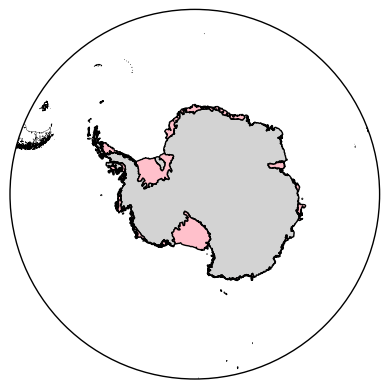

In [4]:

plt.ion()
fig, ax = plt.subplots()

# map boundary
circle = m.drawmapboundary(color='k', linewidth=1)
circle.set_clip_on(False)

# ---- cropped Basemap region ----
for k in range(len(lat_seg)):
    xf, yf = m(lon_seg[k], lat_seg[k])
    m.plot(xf, yf, zorder=1, c='k', linewidth=0.25)

for k in range(len(ilon_land)):
    xf, yf = m(ilon_land[k], ilat_land[k])
    xyf = np.c_[xf, yf]
    poly = polyg(xyf, facecolor='lightgrey', edgecolor='k')
    plt.gca().add_patch(poly)

for k in range(len(ilon_ice)):
    xf, yf = m(ilon_ice[k], ilat_ice[k])
    xyf = np.c_[xf, yf]
    poly = polyg(xyf, facecolor='pink', edgecolor='k')
    plt.gca().add_patch(poly)


In [ ]:
"""
>> this script creates the files that are later used to:
    (1) calculate the distance between pointwise data and nearest land contour and
    (2) mask the land in the gridded data

1. I define a coarse contour to the north of 60S that roughly follows the
South American coast. This is because I couldn't figure out how to extract
it from Basemap (this could be revised).
To the south of 60S, I use the contours of coastline and ice shelves
from the Vic/Holland product.
N.B.: Given the time, there could be a test to see if this step makes
any difference at all.

2. Create a gridded land mask to use with the binned data.
[N.B.: This is not the code that created the land_mask_gridded_50s.nc file!!
I seem to have lost it but this should not make much of a difference and the
approach to obtain it must have been along these lines. The file is more detailed
than the result I get from the script so I would use the file or make your own land mask]

- if any of the corners of a grid cell are inside a land/ice shelf contour then
the grid cell is masked
- there is no set distance from the coast that is masked

Last modified: 12 Nov 2024
"""
# Import modules

import numpy as np
from numpy import ma

import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, cm, ion
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon as polyg

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from copy import deepcopy
import sys

from netCDF4 import Dataset
import pickle

# Define directories
workdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
lmdir = workdir +  'land_masks/'
directorycoast = lmdir + 'holland_vic/'

# Define a GRID that matches the altimetry grid
#--------------------------------------------------------------
edges_lon = np.linspace(-180, 180, num=361, endpoint=True)
edges_lat = np.linspace(-82, -50, num=65, endpoint=True)

glat, glon = np.meshgrid(edges_lat, edges_lon)

mid_lon = 0.5*(edges_lon[1:] + edges_lon[:-1])
mid_lat = 0.5*(edges_lat[1:] + edges_lat[:-1])

gmlat, gmlon = np.meshgrid(mid_lat, mid_lon)
mlondim, mlatdim = gmlon.shape
londim, latdim = glon.shape

# grid of 0s that will have 1s where there is land
grid0 = ma.zeros(glon.shape)
mgrid0 = ma.zeros(gmlon.shape)

#--------------------------------------------------------------
#------------------ Land contour north of 60S -----------------
#--------------------------------------------------------------
# hardcode a contour around South America and the islands between 50S-60S
chile_lon = np.asarray([-75.60, -75.50, -75.63, -75.60, -75.48, -75.40,
			-75.58, -75.55, -75.38, -75.30, -75.37, -75.40,
			-75.38, -75.49, -75.48, -75.49, -75.52, -75.47,
			-75.30, -75.06, -75.10, -75.15, -75.24, -75.22,
			-75.31, -75.34, -75.26, -75.10, -75.14, -75.12,
			-75.01, -74.93, -74.50, -74.68, -74.75, -74.40,
			-74.33, -74.15, -73.93, -73.91, -73.87, -73.73,
			-73.58, -73.33, -73.41, -73.39, -73.50, -73.27,
			-73.22, -72.14, -72.14, -71.97, -71.44, -71.48,
                        -70.92, -70.45, -70.16, -69.20, -68.29, -68.10,
			-67.88, -67.88, -67.60, -67.20, -67.00, -67.15,
			-66.90, -66.40, -66.50, -65.30, -65.25, -64.80,
			-64.70, -64.20, -63.70, -63.70, -64.30, -64.80,
			-65.25, -65.10, -66.00, -67.00, -68.10, -68.25,
			-68.75, -68.35, -68.95, -69.15, -69.10, -68.78,
			-68.15, -67.90, -67.70, -67.65, -67.50, -75.60])

chile_lat = np.asarray([-49.00, -49.08, -49.22, -49.25, -49.28, -49.55,
			-49.66, -49.85, -49.78, -49.90, -50.01, -50.04,
			-50.13, -50.31, -50.41, -50.60, -50.67, -50.78,
			-50.82, -50.85, -51.03, -51.25, -51.35, -51.50,
			-51.55, -51.63, -51.67, -51.74, -51.82, -51.92,
			-52.15, -52.30, -52.65, -52.72, -52.76, -53.11,
			-53.31, -53.39, -53.31, -53.55, -53.63, -53.73,
			-53.79, -53.75, -53.85, -53.94, -54.07, -54.18,
			-54.14, -54.60, -54.66, -54.78, -54.80, -54.93,
                        -55.16, -55.21, -55.33, -55.63, -55.63, -55.72,
			-55.83, -55.87, -55.92, -56.00, -55.86, -55.75,
			-55.35, -55.25, -55.05, -54.90, -54.80, -54.80,
			-54.90, -54.85, -54.78, -54.65, -54.58, -54.80,
			-54.80, -54.60, -54.60, -54.16, -53.40, -52.98,
			-52.57, -52.35, -51.55, -51.00, -50.60, -50.30,
			-50.12, -50.00, -49.80, -49.50, -49.00, -49.00])
# Falklands/Malvinas
isl1_lon = np.asarray([-61.40, -61.40, -61.10, -60.93, -60.65, -60.45,
			-60.18, -59.90, -59.85, -59.70, -59.30, -58.4,
			-57.66, -57.66, -57.90, -59.00, -59.15, -59.90,
			-61.25, -61.26, -60.80, -60.9, -61.4])
isl1_lat = np.asarray([-51.65, -51.82, -52.06, -52.18, -52.27, -52.25,
			-52.05, -52.05, -52.37, -52.41, -52.37, -52.13,
			-51.70, -51.50, -51.33, -51.23, -51.36, -51.19,
			-50.99, -51.03, -51.31, -51.63, -51.65])

isl2_lon = np.asarray([-38.10, -37.40, -36.15, -35.70, -36.20, -36.90, -38.10])
isl2_lat = np.asarray([-54.00, -54.30, -54.95, -54.80, -54.20, -54.00, -54.00])

isl3_lon = [-26.80, -27.70, -27.00, -26.30, -26.20, -26.20, -26.50, -27.40, -27.80, -27.20, -26.80]
isl3_lat = [-58.00, -59.50, -59.60, -59.00, -58.40, -57.70, -57.00, -56.20, -56.20, -57.00, -58.00]

isl4_lon = [3.5, 3.0, 3.5, 3.8, 3.5]
isl4_lat = [-54.6, -54.4, -54.2, -54.4, -54.6]

isl5_lon = [73.90, 73.30, 73.20, 73.50, 73.90]
isl5_lat = [-53.10, -52.95, -53.00, -53.22, -53.10]

#--------------------------------------------------------------
# ALL contours north of 60S
ilon_basemap, ilat_basemap = [], []
for llo, lla in zip([chile_lon, isl1_lon, isl2_lon, isl3_lon, isl4_lon, isl5_lon],
                    [chile_lat, isl1_lat, isl2_lat, isl3_lat, isl4_lat, isl5_lat]):
    ilon_basemap.append(llo)
    ilat_basemap.append(lla)



In [ ]:
#aux_2b

In [6]:
"""
>> this script creates the files that are later used to:
    (1) calculate the distance between pointwise data and nearest land contour and
    (2) mask the land in the gridded data

1. I define a coarse contour to the north of 60S that roughly follows the
South American coast. This is because I couldn't figure out how to extract
it from Basemap (this could be revised).
To the south of 60S, I use the contours of coastline and ice shelves
from the Vic/Holland product.
N.B.: Given the time, there could be a test to see if this step makes
any difference at all.

2. Create a gridded land mask to use with the binned data.
[N.B.: This is not the code that created the land_mask_gridded_50s.nc file!!
I seem to have lost it but this should not make much of a difference and the
approach to obtain it must have been along these lines. The file is more detailed
than the result I get from the script so I would use the file or make your own land mask]

- if any of the corners of a grid cell are inside a land/ice shelf contour then
the grid cell is masked
- there is no set distance from the coast that is masked

Last modified: 12 Nov 2024
"""
# Import modules

import numpy as np
from numpy import ma

import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, cm, ion
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon as polyg

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from copy import deepcopy
import sys

from netCDF4 import Dataset
import pickle

# Define directories
workdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
lmdir = workdir +  'land_masks/'
directorycoast = lmdir + 'holland_vic/'

# Define a GRID that matches the altimetry grid
#--------------------------------------------------------------
edges_lon = np.linspace(-180, 180, num=361, endpoint=True)
edges_lat = np.linspace(-82, -50, num=65, endpoint=True)

glat, glon = np.meshgrid(edges_lat, edges_lon)

mid_lon = 0.5*(edges_lon[1:] + edges_lon[:-1])
mid_lat = 0.5*(edges_lat[1:] + edges_lat[:-1])

gmlat, gmlon = np.meshgrid(mid_lat, mid_lon)
mlondim, mlatdim = gmlon.shape
londim, latdim = glon.shape

# grid of 0s that will have 1s where there is land
grid0 = ma.zeros(glon.shape)
mgrid0 = ma.zeros(gmlon.shape)

#--------------------------------------------------------------
#------------------ Land contour north of 60S -----------------
#--------------------------------------------------------------
# hardcode a contour around South America and the islands between 50S-60S
chile_lon = np.asarray([-75.60, -75.50, -75.63, -75.60, -75.48, -75.40,
			-75.58, -75.55, -75.38, -75.30, -75.37, -75.40,
			-75.38, -75.49, -75.48, -75.49, -75.52, -75.47,
			-75.30, -75.06, -75.10, -75.15, -75.24, -75.22,
			-75.31, -75.34, -75.26, -75.10, -75.14, -75.12,
			-75.01, -74.93, -74.50, -74.68, -74.75, -74.40,
			-74.33, -74.15, -73.93, -73.91, -73.87, -73.73,
			-73.58, -73.33, -73.41, -73.39, -73.50, -73.27,
			-73.22, -72.14, -72.14, -71.97, -71.44, -71.48,
                        -70.92, -70.45, -70.16, -69.20, -68.29, -68.10,
			-67.88, -67.88, -67.60, -67.20, -67.00, -67.15,
			-66.90, -66.40, -66.50, -65.30, -65.25, -64.80,
			-64.70, -64.20, -63.70, -63.70, -64.30, -64.80,
			-65.25, -65.10, -66.00, -67.00, -68.10, -68.25,
			-68.75, -68.35, -68.95, -69.15, -69.10, -68.78,
			-68.15, -67.90, -67.70, -67.65, -67.50, -75.60])

chile_lat = np.asarray([-49.00, -49.08, -49.22, -49.25, -49.28, -49.55,
			-49.66, -49.85, -49.78, -49.90, -50.01, -50.04,
			-50.13, -50.31, -50.41, -50.60, -50.67, -50.78,
			-50.82, -50.85, -51.03, -51.25, -51.35, -51.50,
			-51.55, -51.63, -51.67, -51.74, -51.82, -51.92,
			-52.15, -52.30, -52.65, -52.72, -52.76, -53.11,
			-53.31, -53.39, -53.31, -53.55, -53.63, -53.73,
			-53.79, -53.75, -53.85, -53.94, -54.07, -54.18,
			-54.14, -54.60, -54.66, -54.78, -54.80, -54.93,
                        -55.16, -55.21, -55.33, -55.63, -55.63, -55.72,
			-55.83, -55.87, -55.92, -56.00, -55.86, -55.75,
			-55.35, -55.25, -55.05, -54.90, -54.80, -54.80,
			-54.90, -54.85, -54.78, -54.65, -54.58, -54.80,
			-54.80, -54.60, -54.60, -54.16, -53.40, -52.98,
			-52.57, -52.35, -51.55, -51.00, -50.60, -50.30,
			-50.12, -50.00, -49.80, -49.50, -49.00, -49.00])
# Falklands/Malvinas
isl1_lon = np.asarray([-61.40, -61.40, -61.10, -60.93, -60.65, -60.45,
			-60.18, -59.90, -59.85, -59.70, -59.30, -58.4,
			-57.66, -57.66, -57.90, -59.00, -59.15, -59.90,
			-61.25, -61.26, -60.80, -60.9, -61.4])
isl1_lat = np.asarray([-51.65, -51.82, -52.06, -52.18, -52.27, -52.25,
			-52.05, -52.05, -52.37, -52.41, -52.37, -52.13,
			-51.70, -51.50, -51.33, -51.23, -51.36, -51.19,
			-50.99, -51.03, -51.31, -51.63, -51.65])

isl2_lon = np.asarray([-38.10, -37.40, -36.15, -35.70, -36.20, -36.90, -38.10])
isl2_lat = np.asarray([-54.00, -54.30, -54.95, -54.80, -54.20, -54.00, -54.00])

isl3_lon = [-26.80, -27.70, -27.00, -26.30, -26.20, -26.20, -26.50, -27.40, -27.80, -27.20, -26.80]
isl3_lat = [-58.00, -59.50, -59.60, -59.00, -58.40, -57.70, -57.00, -56.20, -56.20, -57.00, -58.00]

isl4_lon = [3.5, 3.0, 3.5, 3.8, 3.5]
isl4_lat = [-54.6, -54.4, -54.2, -54.4, -54.6]

isl5_lon = [73.90, 73.30, 73.20, 73.50, 73.90]
isl5_lat = [-53.10, -52.95, -53.00, -53.22, -53.10]

#--------------------------------------------------------------
# ALL contours north of 60S
ilon_basemap, ilat_basemap = [], []
for llo, lla in zip([chile_lon, isl1_lon, isl2_lon, isl3_lon, isl4_lon, isl5_lon],
                    [chile_lat, isl1_lat, isl2_lat, isl3_lat, isl4_lat, isl5_lat]):
    ilon_basemap.append(llo)
    ilat_basemap.append(lla)

In [7]:
#--------------------------------------------------------------
#------------------ COASTLINES south of 60S -----------------
#--------------------------------------------------------------
print("Importing Antarctic Digital Database shapefile. \n")
# add path to coastline files
sys.path.append(directorycoast)
from coastline_Antarctica import coastline

# extract coastline points from files (Tiago/Paul Holland)
## it returns a list of lists
[ilon_land, ilat_land, ilon_ice, ilat_ice] = coastline()

# combine contours from both land and ice shelves
# ilon = np.hstack((ilon_land, ilon_ice, ilon_basemap))
# ilat = np.hstack((ilat_land, ilat_ice, ilat_basemap))

ilon = ilon_land + ilon_ice + ilon_basemap
ilat = ilat_land + ilat_ice + ilat_basemap

#--------------------------------------------------------------
# 1. file used to calculate distance to land
#--------------------------------------------------------------
# coast = np.vstack((ilon, ilat))

coast = (ilon, ilat)


with open(lmdir+'coastline_nested_lists.pkl', 'wb') as f:
    pickle.dump(coast, f)
#--------------------------------------------------------------
#--------------------------------------------------------------
#--------------------------------------------------------------
# 2. Gridded land mask
#--------------------------------------------------------------
# pick land contour 10 (biggest area, main coastline):
clon = np.asarray([float(item) for item in ilon[10]])
clat = np.asarray([float(item) for item in ilat[10]])

# contour
lonlat_arr = np.column_stack((clon, clat))
polygon = Polygon(lonlat_arr)

# if any of the corners of a grid cell is inside a contour then mask the cell
for lo in range(1, londim-1):
    for la in range(1, latdim-1):
        point = Point(glon[lo, la], glat[lo, la])
        if polygon.contains(point) == True:
            mgrid0[lo-1, la-1] = mgrid0[lo-1, la] = 1
            mgrid0[lo, la-1] = mgrid0[lo, la] = 1


# indices along the lon/lat dimensions
ind_lon = np.arange(len(edges_lon))[:, np.newaxis]*ma.ones((glon.shape))
ind_lat = np.arange(len(edges_lat))*ma.ones((glat.shape))

ind_lon = ind_lon.flatten()
ind_lat = ind_lat.flatten()

# data lon are -180/180;
# need to change to +ve lons for the contour that crosses the 180/-180 meridian
glon1 = glon.flatten()
glon_pos = deepcopy(glon1)
glon_pos[glon_pos<0] = glon_pos[glon_pos<0] + 360

fglat = glat.flatten()

imask_lo, imask_la = [], []
# contours info:
# land: 10 = largest one, main grounding line - analyse separately because it
# needs to be broken down into smaller segments
# ice (+land, +208): 45 (253) = Ronne, 95 (303) = Ross
for i in range(len(ilon)):
    if i != 10:  # this contour will be dealt with separately
        # 1. contour lat/lon
        clon = np.asarray([float(item) for item in ilon[i]])
        clat = np.asarray([float(item) for item in ilat[i]])

        if i == 303: # Ross Sea (across the discontinuity -180/180)
            clon[clon<0] = clon[clon<0] + 360
            fglon = glon_pos
        else:
            fglon = glon1

        # 3. create a polygon
        lonlat = np.column_stack((clon, clat))
        polygon = Polygon(lonlat)

        for j in range(len(ind_lon)):
            point = Point(fglon[j], fglat[j])
            if polygon.contains(point) == True:
                imask_lo.append(ind_lon[j])
                imask_la.append(ind_lat[j])

iilo = np.asarray([int(imask_lo[i]) for i in range(len(imask_lo))])
iila = np.asarray([int(imask_la[i]) for i in range(len(imask_la))])

ilo0 = ma. masked_outside(iilo, 1, 359)
ila0 = ma.masked_array(iila, ilo0.mask)
ila = ma.masked_outside(ila0, 1, 59)
ilo = ilo0[~ila.mask]
ila = ila[~ila.mask]

mgrid0[ilo, ila] = 1
mgrid0[ilo-1, ila-1] = 1
mgrid0[ilo-1, ila] = 1
mgrid0[ilo, ila-1] = 1

# save mask to a file /// commented this out so as not to replace the file I used
newfile = 'land_mask_gridded_50s_v2.nc' # edited the name just in case
dataset = Dataset(lmdir+newfile, 'w')

# dimensions
dataset.createDimension('mlon', mlondim)
dataset.createDimension('mlat', mlatdim)
dataset.createDimension('elon', londim)
dataset.createDimension('elat', latdim)

# variables
landmask = dataset.createVariable('landmask', np.float64, ('mlon', 'mlat'))
mlati = dataset.createVariable('mid_latitude', np.float64, ('mlon', 'mlat'))
mlongi = dataset.createVariable('mid_longitude', np.float64, ('mlon', 'mlat'))
elati = dataset.createVariable('edge_latitude', np.float64, ('elon', 'elat'))
elongi = dataset.createVariable('edge_longitude', np.float64, ('elon', 'elat'))

dataset.description = ("Gridded land mask south of 50S (land=1, ocean=0). (0.5 lat x 1 lon)")
landmask[:] = mgrid0
mlati[:] = gmlon
mlongi[:] = gmlat
elati[:] = glat
elongi[:] = glon

dataset.close()



Importing Antarctic Digital Database shapefile. 



{-50: ([<matplotlib.lines.Line2D at 0x12b08c1d0>], []),
 -60: ([<matplotlib.lines.Line2D at 0x139c8e120>], []),
 -80.0: ([<matplotlib.lines.Line2D at 0x12b08ff50>], [])}

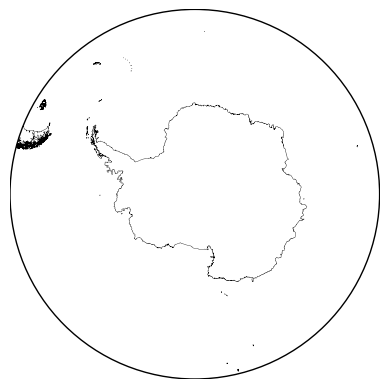

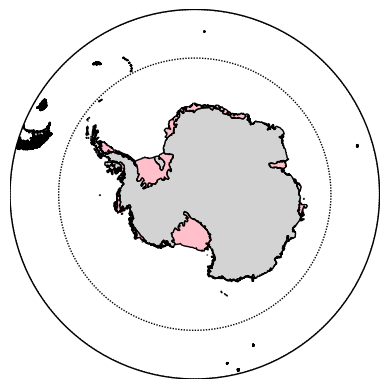

In [10]:

#--------------------------------------------------------------
# PLOT
#--------------------------------------------------------------
# coastline resolution can vary from coarse to fine: c, l, i, h, f
m = Basemap(projection='spstere',
            boundinglat=-50.,
            lon_0=180,
            round=True,
            resolution='h',
            ellps='WGS84')

basemap_coast = m.drawcoastlines(linewidth=0.25)
segments = basemap_coast.get_segments()
lat_seg, lon_seg = [], []

# get only contours to the north of 60S from basemap
for j in range(len(segments)):
    xy = np.vstack(segments[j])
    lons_b, lats_b = m(xy[:, 0], xy[:, 1], inverse=True)
    lats_bm = ma.masked_less(lats_b, -60)
    if lats_bm.count() > 0:
        lat_seg.append(lats_b)
        lon_seg.append(lons_b)

# --- begin figure
fig, ax = plt.subplots()
for k in range(len(ilon_land)):
    xf, yf = m(ilon_land[k], ilat_land[k])
    xyf = np.c_[xf, yf]
    poly = polyg(xyf, facecolor='lightgrey',
                  zorder=3, edgecolor='k')
    ax.add_patch(poly)

for k in range(len(ilon_ice)):
    xf, yf = m(ilon_ice[k], ilat_ice[k])
    xyf = np.c_[xf, yf]
    poly = polyg(xyf, facecolor='pink',
                  zorder=3, edgecolor='k')
    ax.add_patch(poly)

# ---- cropped Basemap region ----
for k in range(len(lat_seg)):
    xf, yf = m(lon_seg[k], lat_seg[k])
    m.plot(xf, yf, zorder=3, c='k')

m.pcolormesh(glon, glat, mgrid0, alpha=0.6, cmap=cm.Blues, latlon=True, zorder=4)
m.drawparallels([-50, -60])


# m.scatter(glon, glat, c='grey', s=5, latlon=True, zorder=4)
# m.scatter(gmlon, gmlat, c='c', s=5, latlon=True, zorder=4)



In [2]:
# aux_3a

"""
coarsen the topography grid from GEBCO to match the altimetry resolution

Last modified: 16 Mar 2021
"""
import numpy as np

import xarray as xr

from scipy.interpolate import RegularGridInterpolator as rgi

import sys

# Directories
workdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
altdir = workdir + 'altimetry_cpom/1_raw_nc/'
lmdir = workdir + 'land_masks/'
topodir = workdir + 'topog/'

#-------------------------------------------------------------------
# bathymetry file
with xr.open_dataset(topodir + 'gebco_all.nc') as topo:
    print(topo.keys())

print("\n reading altimetry data..")
# --------------------------------------------------------
# altfile = #'insert_here_the_altimetry_file.nc'

altfile = '/201012_MERGE.nc'
print(altfile)

# with xr.open_dataset(altdir+altfile) as alt:
with xr.open_dataset(altdir+ altfile) as alt:
    print(alt.keys())

# topog grid only covers -50 to -78
# define the new grid within those bounds otherwise the interp fc complains
fc = rgi((topo.lon.values, topo.lat.values), topo.elevation.values.T)

# grid - lon goes from 0 to 360 in topog
alat = alt.Latitude.sel(Latitude=slice(topo.lat.min(), topo.lat.max())).values
alon = alt.Longitude.values
alon[alon<0] = alon[alon<0] + 360

glat, glon = np.meshgrid(alat, alon)

# coarser topography
coarse_elev = fc((glon, glat))

# --------------------------------------------------------
# save coarser topog in a new file
coarse_topog = xr.Dataset({'elevation': (['lon', 'lat'], coarse_elev)},
                          coords={'lon': alon, 'lat': alat})
fname = 'coarse_gebco_p5x1_latlon.nc'
coarse_topog.to_netcdf(topodir+ fname)
print("File saved in %s as %s" % (topodir, fname))


KeysView(<xarray.Dataset> Size: 2GB
Dimensions:    (lat: 6720, lon: 86400)
Coordinates:
  * lat        (lat) float64 54kB -78.0 -77.99 -77.99 ... -50.01 -50.01 -50.0
  * lon        (lon) float64 691kB 0.002083 0.00625 0.01042 ... 360.0 360.0
Data variables:
    elevation  (lat, lon) float32 2GB ...
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO_2019 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The GEBCO_2019 Grid is the latest global bathymetric produc...
    history:      Information on the development of the data set and the sour...
    references:   DOI: 10.5285/836f016a-33be-6ddc-e053-6c86abc0788e
    comment:      The data in the GEBCO_2019 Grid should not be used for navi...
    node_offset:  1.0)

 reading altimetry data..
/201012_MERGE.nc
KeysView(<xarray.Dataset> Size: 182MB
Dimensions:       (nrows: 2170192)
Dimensions without coordinates: nrows
Data variabl

KeyError: "'Latitude' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'nrows': 2170192})"

In [4]:
with xr.open_dataset(altdir + altfile) as alt:
    print(alt.keys())
    print(alt.dims)
    print(alt.coords)



KeysView(<xarray.Dataset> Size: 182MB
Dimensions:       (nrows: 2170192)
Dimensions without coordinates: nrows
Data variables: (12/13)
    SurfaceType   (nrows) int32 9MB ...
    Time          (nrows) datetime64[ns] 17MB ...
    Latitude      (nrows) float64 17MB ...
    Longitude     (nrows) float64 17MB ...
    Elevation     (nrows) float64 17MB ...
    MeanSSH       (nrows) float64 17MB ...
    ...            ...
    track_dir     (nrows) int32 9MB ...
    ice_conc      (nrows) float64 17MB ...
    sea_ice_type  (nrows) int32 9MB ...
    conf_sit      (nrows) float64 17MB ...
    Retracker     (nrows) float64 17MB ...
    distance_m    (nrows) float32 9MB ...
Attributes:
    description:  Monthly <YearMonth> altimetry record containing:           ...
    history:      Created 24/03/2025, 11:0449)
FrozenMappingWarningOnValuesAccess({'nrows': 2170192})
Coordinates:
    *empty*


In [6]:
import numpy as np
import xarray as xr
from scipy.interpolate import RegularGridInterpolator as rgi

# Directories
workdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
altdir = workdir + 'altimetry_cpom/1_raw_nc/'
topodir = workdir + 'topog/'

#-------------------------------------------------------------------
# Load bathymetry (topography) dataset
with xr.open_dataset(topodir + 'gebco_all.nc') as topo:
    print(topo.keys())

    # Create interpolation function for topo elevation
    # Note topo.lon: 0 to 360; topo.lat as coords
    fc = rgi((topo.lon.values, topo.lat.values), topo.elevation.values.T)

print("\nReading altimetry data...")
altfile = '/201012_MERGE.nc'
with xr.open_dataset(altdir + altfile) as alt:
    print(alt.keys())

    # Extract latitude and longitude arrays from altimetry data variables (dimension: nrows)
    lat_arr = alt['Latitude'].values
    lon_arr = alt['Longitude'].values

    # Define latitude limits from topo grid (assuming topo.lat is coordinate)
    lat_min = topo.lat.min().values
    lat_max = topo.lat.max().values

    # Create mask to filter altimetry points within topo latitude bounds
    mask = (lat_arr >= lat_min) & (lat_arr <= lat_max)

    # Filter lat/lon arrays using mask
    alat = lat_arr[mask]
    alon = lon_arr[mask]

    # Convert negative longitudes to 0-360 range for consistency with topo lon
    alon = np.where(alon < 0, alon + 360, alon)

    # Since altimetry points are irregularly spaced, create a regular lat/lon grid
    # Define grid resolution (adjust these numbers as needed)
    num_lon = 360  # e.g., 0.5 deg resolution: 360 points for 0-360
    num_lat = 280  # e.g., covering topo lat range with ~0.25 deg spacing

    glon_vals = np.linspace(topo.lon.min().values, topo.lon.max().values, num=num_lon)
    glat_vals = np.linspace(topo.lat.min().values, topo.lat.max().values, num=num_lat)
    glon, glat = np.meshgrid(glon_vals, glat_vals)

    # Interpolate topo elevation onto this regular grid
    coarse_elev = fc((glon, glat))

# --------------------------------------------------------
# Save coarser topography on new lat/lon grid
coarse_topog = xr.Dataset(
    {'elevation': (['lat', 'lon'], coarse_elev)},  # note: meshgrid defaults shape is (lat, lon)
    coords={'lat': glat_vals, 'lon': glon_vals}
)
fname = 'coarse_gebco_p5x1_latlon_izzy.nc'
coarse_topog.to_netcdf(topodir + fname)
print(f"File saved in {topodir} as {fname}")


KeysView(<xarray.Dataset> Size: 2GB
Dimensions:    (lat: 6720, lon: 86400)
Coordinates:
  * lat        (lat) float64 54kB -78.0 -77.99 -77.99 ... -50.01 -50.01 -50.0
  * lon        (lon) float64 691kB 0.002083 0.00625 0.01042 ... 360.0 360.0
Data variables:
    elevation  (lat, lon) float32 2GB ...
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO_2019 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The GEBCO_2019 Grid is the latest global bathymetric produc...
    history:      Information on the development of the data set and the sour...
    references:   DOI: 10.5285/836f016a-33be-6ddc-e053-6c86abc0788e
    comment:      The data in the GEBCO_2019 Grid should not be used for navi...
    node_offset:  1.0)

Reading altimetry data...
KeysView(<xarray.Dataset> Size: 182MB
Dimensions:       (nrows: 2170192)
Dimensions without coordinates: nrows
Data variables: (12/13)
    S

In [9]:
"""
coarsen the topography grid from GEBCO to match the altimetry resolution

Last modified: 16 Mar 2021 --- USING THE ALL_30B_MEDIAN FILE (CHECK WHEN THIS IS CREATED , IS IT USED RETROSPECITIVELY?)
"""
import numpy as np

import xarray as xr

from scipy.interpolate import RegularGridInterpolator as rgi

import sys

# Directories
workdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
altdir = workdir + '/altimetry_cpom/3_grid_dot/'
lmdir = workdir + 'land_masks/'
topodir = workdir + 'topog/'

#-------------------------------------------------------------------
# bathymetry file
with xr.open_dataset(topodir + 'gebco_all.nc') as topo:
    print(topo.keys())

print("\n reading altimetry data..")
# --------------------------------------------------------
# altfile = #'insert_here_the_altimetry_file.nc'

altfile = '/dot_all_30bmedian_goco05c_sig3_1.nc'
print(altfile)

# with xr.open_dataset(altdir+altfile) as alt:
with xr.open_dataset(altdir+ altfile) as alt:
    print(alt.keys())

# topog grid only covers -50 to -78
# define the new grid within those bounds otherwise the interp fc complains
fc = rgi((topo.lon.values, topo.lat.values), topo.elevation.values.T)

# grid - lon goes from 0 to 360 in topog
alat = alt.latitude.sel(latitude=slice(topo.lat.min(), topo.lat.max())).values
alon = alt.longitude.values
alon[alon<0] = alon[alon<0] + 360

glat, glon = np.meshgrid(alat, alon)

# coarser topography
coarse_elev = fc((glon, glat))

# --------------------------------------------------------
# save coarser topog in a new file
coarse_topog = xr.Dataset({'elevation': (['lon', 'lat'], coarse_elev)},
                          coords={'lon': alon, 'lat': alat})
fname = 'coarse_gebco_p5x1_latlon_all_test_izzy.nc'
coarse_topog.to_netcdf(topodir+ fname)
print("File saved in %s as %s" % (topodir, fname))



KeysView(<xarray.Dataset> Size: 2GB
Dimensions:    (lat: 6720, lon: 86400)
Coordinates:
  * lat        (lat) float64 54kB -78.0 -77.99 -77.99 ... -50.01 -50.01 -50.0
  * lon        (lon) float64 691kB 0.002083 0.00625 0.01042 ... 360.0 360.0
Data variables:
    elevation  (lat, lon) float32 2GB ...
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO_2019 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The GEBCO_2019 Grid is the latest global bathymetric produc...
    history:      Information on the development of the data set and the sour...
    references:   DOI: 10.5285/836f016a-33be-6ddc-e053-6c86abc0788e
    comment:      The data in the GEBCO_2019 Grid should not be used for navi...
    node_offset:  1.0)

 reading altimetry data..
/dot_all_30bmedian_goco05c_sig3_1.nc
KeysView(<xarray.Dataset> Size: 109MB
Dimensions:          (longitude: 360, latitude: 64, time: 196, ed

KeysView(<xarray.Dataset> Size: 109MB
Dimensions:          (longitude: 360, latitude: 64, time: 196, edge_lat: 65,
                      edge_lon: 361)
Coordinates:
  * longitude        (longitude) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * latitude         (latitude) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * time             (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * edge_lat         (edge_lat) float64 520B -82.0 -81.5 -81.0 ... -50.5 -50.0
  * edge_lon         (edge_lon) float64 3kB -180.0 -179.0 -178.0 ... 179.0 180.0
Data variables:
    dot              (longitude, latitude, time) float64 36MB ...
    ug               (longitude, latitude, time) float64 36MB ...
    vg               (longitude, latitude, time) float64 36MB ...
    land_mask        (longitude, latitude) float64 184kB ...
    intersat_offset  float64 8B ...
Attributes:
    history:      Created 08/01/2022, 00:5223
    description:  ENVISAT + CryoSat2 altimetry (geoid:_goco05c) \nenv: 07.200...)

/var/folders/_b/mwrrgwfd7k53y4lg7_zfzvjm0000gp/T/ipykernel_35609/767225951.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('bone_r', 11)
/var/folders/_b/mwrrgwfd7k53y4lg7_zfzvjm0000gp/T/ipykernel_35609/767225951.py:100: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  lp.collections[i].set_label(lp_labels[i])


figure 2
KeysView(<xarray.Dataset> Size: 201kB
Dimensions:     (lon: 360, lat: 64, c: 570)
Coordinates:
  * lon         (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat         (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * c           (c) int64 5kB 0 1 2 3 4 5 6 7 ... 563 564 565 566 567 568 569
Data variables:
    bathy_mask  (lon, lat) float64 184kB ...
    llon        (c) float64 5kB ...
    llat        (c) float64 5kB ...)


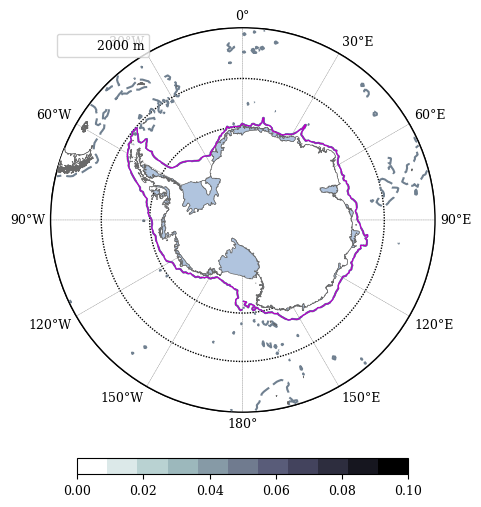

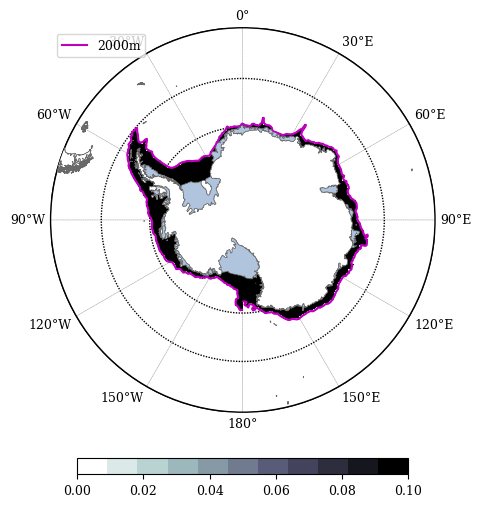

In [39]:
#3b
"""
Creates a mask to extract a variable inside a chosen
bathymetry contour (gridded on the altimetry grid)

> can choose to leave out the Antarctic peninsula and mask grid points
 that are less than 10 km from the coastline but the latter can be done later

Last modified: 27 Jun 2023
"""
import numpy as np
from numpy import ma

import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from shapely.geometry.polygon import Polygon
from shapely.geometry import Point

import sys

#-------------------------------------------------------------------
# Directories
#-------------------------------------------------------------------
voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
griddir = voldir + '/altimetry_cpom/3_grid_dot/'
eradir = voldir + 'reanalyses/'
topodir = voldir + 'topog/'



scriptdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts'
auxscriptdir = scriptdir + 'aux_func/'
sys.path.append(auxscriptdir)
import aux_stereoplot as st

#-------------------------------------------------------------------
# altimetry file
#-------------------------------------------------------------------
geoidtype = 'goco05c'#'eigen6s4v2' # 'goco05c', 'egm08'
satellite = 'all'
#sigma = '3'
#altfile = 'dot_' + satellite + '_30bmedian_' + geoidtype + '_sig' + str(sigma) + '.nc'
sigma = '3_1'
altfile = 'dot_' + satellite + '_30bmedian_' + geoidtype + '_sig' + sigma + '.nc'

#-------------------------------------------------------------------
# load altimetry file
with xr.open_dataset(griddir+altfile) as alt:
    print(alt.keys())

# GRID coordinates
# at bin edges
alt_eglat, alt_eglon = np.meshgrid(alt.edge_lat, alt.edge_lon)
# at bin centres
alt_glat, alt_glon = np.meshgrid(alt.latitude, alt.longitude)

#-----------------------------------
# bathymetry file
with xr.open_dataset(topodir + 'coarse_gebco_p5x1_latlon.nc') as topo:
    print(topo.keys())
tglat, tglon = np.meshgrid(topo.lat, topo.lon)
#-----------------------------------

cbar_range = [0, .1]
cmap = cm.get_cmap('bone_r', 11)
cbar_units = ''
# cbar_extend = 'neither' - this was oana's
cbar_extend ='m'

# intialize and array
shelf = ma.zeros(alt_glat.shape)


# fig, ax = plt.subplots()
# cs = plt.contour(tglat, tglon, topo.elevation, levels=[-2000]).collections


# for contour in cs:
#     paths = contour.get_paths()
#     for path in paths:
#         vertices = path.vertices
#         for x, y in vertices:
#             print(f"({x:.2f}, {y:.2f})")

plt.ion()
print('figure 1')
fig, ax, m = st.spstere_plot(alt_eglon, alt_eglat, shelf,
                       cbar_range, cmap, cbar_units, cbar_extend)

#bathymetry contours
lp = m.contour(tglon, tglat, topo.elevation,
          levels=[-2000],
          colors=['slategray'],
          latlon=True, zorder=2)
lp_labels = ['2000 m']
for i in range(len(lp_labels)):
    lp.collections[i].set_label(lp_labels[i])
ax.legend(loc=2, fontsize=9)

#------------------------------------------------
# extract contour coords from bathym contour plot
lpsegs = lp.allsegs[0][:]

# find the longest contours - this marks the shelf break
mm, idx = 0, 0
for i in range(len(lpsegs)):
    a = lpsegs[i]
    if mm < len(a):
        mm = len(a)
        idx = i
#extract that contour (first one for 2000m)
cc = lpsegs[idx]
#convert into geophys coords and crop the Ant Peninsula
llon, llat = m(cc[:, 0], cc[:,1], inverse=True)

# crop Antarctic peninsula
#llat[(llon>-85)&(llon<-61)] = -70
#llat[(llon>-61)&(llon<-20)] = -74

#------------------------------------------------
m.plot(llon, llat, color='c',latlon=True, lw=1)
#figname = 'shelf_contour_3000m.png'
#fig2.savefig(figdir+figname, dpi=fig2.dpi*2)

from scipy import stats

#a = stats.binned_statistic_2d(llon, llat, None, bins=[alt_eglat, alt_eglon]) - oana original script


lon_bins = alt.edge_lon.values  # 1D array of edges along longitude
lat_bins = alt.edge_lat.values  # 1D array of edges along latitude
a = stats.binned_statistic_2d(llon, llat, None, statistic ='count' , bins=[lon_bins, lat_bins])


# grid llon and llat onto the altimetry
from scipy.interpolate import griddata

# Interpolate the contour line onto the grid
zi = griddata((llat, llon), np.ones_like(llat), (alt_glat, alt_glon), method="linear")


#------------------------------------------------
# create a polygon from the contour's lat/lon
llon_c = np.hstack((llon, llon[-1]))
llat_c = np.hstack((llat, llat[-1]))
xc, yc = m(llon_c, llat_c)
xy_c = np.column_stack((xc, yc))
xy_topog_poly = Polygon(xy_c)

# check what grid points are inside
xd, yd = m(alt_glon, alt_glat)
r, c = xd.shape

for i in range(r):
    for j in range(c):
        point = Point(xd[i, j], yd[i, j])
        #if alt.land_mask.values[i, j] == 0: # not on land
        if xy_topog_poly.contains(point):
            shelf[i, j] = 1
#shelf[alt.land_mask==1]=0
#shelf = ma.masked_equal(shelf, 1)

# values inside the contour but outside the land mask are 1;
# everything else is 0
#------------------------------------------------
alt_glon[shelf!=1] = np.nan
alt_glat[shelf!=1] = np.nan

contour_lat = np.nanmax(alt_glat, axis=1)
contour_lon = alt.longitude.values
#------------------------------------------------
print("figure 2")
plt.ion()
fig, ax, m = st.spstere_plot(alt_eglon, alt_eglat, shelf,
                       cbar_range, cmap, cbar_units, cbar_extend)
#bathymetry contours
lp = m.plot(llon, llat, color= 'm',
         latlon=True, zorder=2, label='2000m')
ax.legend(loc=2, fontsize=9)


#------------------------------------------------

ds = xr.Dataset({'bathy_mask' : (('lon', 'lat'), shelf),
                'llon' : ('c', llon),
                'llat' : ('c', llat)},
                coords={'lon' : alt.longitude.values,
                'lat' : alt.latitude.values,
                'c' : np.arange(len(llon))})
ds.bathy_mask.attrs["comments"] = "1=ocean region inside a 2000m bathymetry contour (GEBCO), 0=discard/mask"
ds.llon.attrs["long_name"] = "lon of the bathy contour"
ds.llat.attrs["long_name"] = "lat of the bathy contour"

ds.to_netcdf(topodir + 'bathy_mask_2km.nc')

#------------------------------------------------
# check file
with xr.open_dataset(topodir + 'bathy_mask_2km.nc') as nds:
  print(nds.keys())


In [36]:
print('lon_bins shape:', lon_bins.shape)
print('lat_bins shape:', lat_bins.shape)
print('llon shape', llon.shape)
print('llat shape', llat.shape)
print('alt_eglat shape', alt_eglat.shape)
print('alt_eglon shape', alt_eglon.shape)

lon_bins shape: (361,)
lat_bins shape: (65,)
llon shape (570,)
llat shape (570,)
alt_eglat shape (361, 65)
alt_eglon shape (361, 65)


In [29]:
llon.shape

(570,)

In [30]:
llon.ravel().shape

(570,)